In [1]:
from sklearn.linear_model import SGDRegressor
model = SGDRegressor()
model.partial_fit([[0,0]], [0])
model.predict([[0, 0]])

C:\Users\FlorianHuber\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


array([0.])

In [2]:
model.predict([[0, 1]])

array([0.])

In [3]:
model.partial_fit([[1,0]],[1])

C:\Users\FlorianHuber\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


SGDRegressor(alpha=0.0001, average=False, epsilon=0.1, eta0=0.01,
       fit_intercept=True, l1_ratio=0.15, learning_rate='invscaling',
       loss='squared_loss', max_iter=None, n_iter=None, penalty='l2',
       power_t=0.25, random_state=None, shuffle=True, tol=None, verbose=0,
       warm_start=False)

In [267]:
import numpy as np
import gym
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import FeatureUnion

env = gym.make('MountainCar-v0')

def get_transformer():
    sampler = RBFSampler(gamma=2.0, n_components=1000, random_state=1234)
    """n_components=500
    sampler = FeatureUnion([
            ("rbf1", RBFSampler(gamma=5.0, n_components=n_components)),
            ("rbf2", RBFSampler(gamma=2.0, n_components=n_components)),
            ("rbf3", RBFSampler(gamma=1.0, n_components=n_components)),
            ("rbf4", RBFSampler(gamma=0.5, n_components=n_components))
            ])"""
    
    scaler = StandardScaler()

    observation_sample = np.vstack([env.observation_space.sample() for i in range(10000)])
    scaler.fit(observation_sample)
    
    return sampler.fit(scaler.transform(observation_sample)), scaler 

In [272]:
from sklearn.kernel_approximation import RBFSampler

observation = env.reset()
transformer, scaler = get_transformer()
transformed_observation = transformer.transform([observation])
print('transformed_observation.shape',transformed_observation.shape)
models = [SGDRegressor() for i in range(env.action_space.n)]
for model in models:
    model.partial_fit(transformed_observation,[0])

transformed_observation.shape (1, 1000)


C:\Users\FlorianHuber\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


In [285]:
def decide_action(predictions, epsilon):
    if np.random.random() < epsilon:
        return env.action_space.sample()
    else:
        return np.argmax(np.stack(predictions).T)
        
        
def run(env, gamma, epsilon, render = False):
    observation = env.reset()
    # Transform observation (into higher dimensional feature space)
    transformed_observation = transformer.transform(scaler.transform([observation]))
    
    done = False
    action = None
    total_reward = 0
    while(done == False):        

        # Make prediction
        predictions = [m.predict(transformed_observation) for m in models]

        action = decide_action(predictions, epsilon)

        next_observation, reward, done, info = env.step(action)
        
        next_transformed_observation = transformer.transform(scaler.transform([next_observation]))
        
        next_predictions = [m.predict(next_transformed_observation) for m in models]
        new_value = reward + gamma * max(next_predictions)
        
        # Update models
        models[action].partial_fit(transformed_observation, [new_value[0]])
        
        # Update observation:
        observation = next_observation
        transformed_observation = next_transformed_observation
        
        if(render):
            env.render()
        total_reward += reward
        
    if(render):
        env.close()
    return total_reward 



In [286]:
#rewards = []
for i in range(20):
    for i in range(20):
        rewards.append(run(env, 0.99, 0.001))
    
    print(rewards[-1])
    #print(np.mean([run(env, 0.9) for i in range(20)]))
#     run(env, render=True)

C:\Users\FlorianHuber\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


-157.0
-157.0
-151.0
-158.0
-149.0
-154.0
-155.0
-161.0
-160.0
-148.0
-158.0
-164.0
-164.0
-158.0
-151.0
-161.0
-160.0
-161.0
-171.0
-165.0


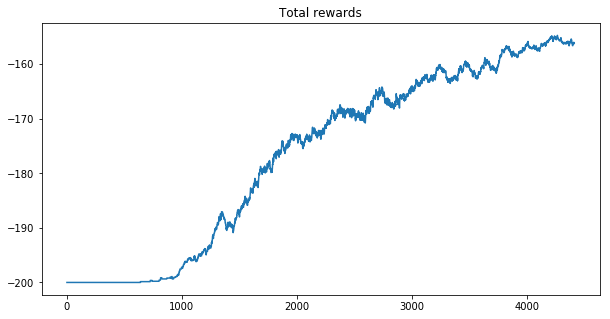

In [287]:
import matplotlib.pyplot as plt

rewards_array = np.array(rewards)
avg_reward = []
avg_over = 100
for i in range(len(rewards)):
    avg_reward.append(rewards_array[max(0, i - avg_over):(i +1)].mean())

fig = plt.figure(figsize=(10, 5))
#plt.plot(rewards)
plt.plot(avg_reward)
plt.title("Total rewards")
plt.show()

In [292]:
# display one run
run(env, 0.99, 0.0, render = True)

C:\Users\FlorianHuber\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


-156.0

In [243]:
action = 1
next_observation, reward, done, info = env.step(action)
print(next_observation, reward)
print(transformer.transform([next_observation])[0][:20])

[-5.26719647e-01 -2.67912820e-04] -1.0
[-0.04068231 -0.0632352   0.04236201 -0.0618868   0.00198771  0.06286966
 -0.01759054  0.00916721 -0.06232915  0.04857261  0.05658071 -0.04175123
  0.01565441 -0.01904836  0.06323999  0.00160379  0.04682458  0.06302005
  0.02869552  0.0604617 ]


In [244]:
scaler.transform([next_observation])

array([[-0.4250226,  0.00044  ]])

In [245]:
predictions = [m.predict(transformer.transform([next_observation])) for m in models]
print(np.argmax(np.stack(predictions).T))
print([m.predict(transformer.transform([next_observation])) for m in models])

2
[array([-43.05265893]), array([-43.03955614]), array([-43.0311854])]


In [21]:
next_transformed_observation = transformer.transform([next_observation])
next_predictions = [m.predict(next_transformed_observation) for m in models]

In [22]:
next_predictions

[array([0.]), array([0.]), array([0.])]

In [215]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
observation_sample = np.vstack([env.observation_space.sample() for i in range(10000)])
scaler.fit(observation_sample)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [222]:
next_observation_scaled = scaler.transform([next_observation])

In [225]:
print(next_observation_scaled, next_observation)

[[-0.5064451  -0.08041898]] [-0.56120488 -0.0028085 ]
